# IAPR: PROJECT

**Group ID:** 45

**Author 1:** Romane Michèle Paula Vorwald (326675)  
**Author 2:** Thomas Van Spaendonk (344550)   
**Author 3:** Sina Philine Eutebach (404298) 

In [48]:
# Import main packages
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize
from skimage.measure import moments, moments_central, moments_normalized, moments_hu
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf


from PIL import Image
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable

## Useful functions & definitions

In [2]:
def load_and_show_image(path_to_img):
    assert os.path.exists(path_to_img), "ERROR: Image not found"
    img = np.array(Image.open(path_to_img))

    # Display image
    plt.imshow(img)
    plt.axis('off')
    return img

In [3]:
def load_labels_csv(data_path):
    """
    Load the training-dataset label file.

    Parameters
    ----------
    data_path : str
        Path to the CSV file that contains:
        ┌──────────────┬───────────────┬───┬───────────────┐
        │ image_name   │ choco_type_01 │ … │ choco_type_13 │
        └──────────────┴───────────────┴───┴───────────────┘
        (one header row + one data row per training image)

    Returns
    -------
    filenames : np.ndarray, shape (N,)
        1D array with the JPEG/PNG filenames for the N training images
        (exact strings as they appear in the first column).

    counts    : np.ndarray, shape (N, 13)
        Integer matrix where each row holds the 13 chocolate type counts
        for the corresponding image.
    """

    df = pd.read_csv(data_path)
    filenames = df.iloc[:, 0].to_numpy()
    counts = df.iloc[:, 1:].to_numpy(dtype=int)

    return filenames, counts

In [4]:
def extract_label(images: np.ndarray, labels: np.ndarray, target_label: int):
    """
    The function returns only the images that have target_label as labels.
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images
    labels: np.ndarray (N)
        List of labels associated with the input image
    target_label: int
        Selected target label

    Return
    ------
    img_extract: np.ndarray (M, 28, 28)
        Extracted images that have target_label as label (M should be lower than N).
    """

    n, d, _ = np.shape(images) 
    img_extract = np.zeros((30, d, d))
    
    # ------------------
    # Your code here ... 
    # ------------------

    selected_img = []

    for i in range(n):
        if labels[i] == target_label:
            selected_img.append(images[i])

    img_extract = np.array(selected_img)
    
    return img_extract

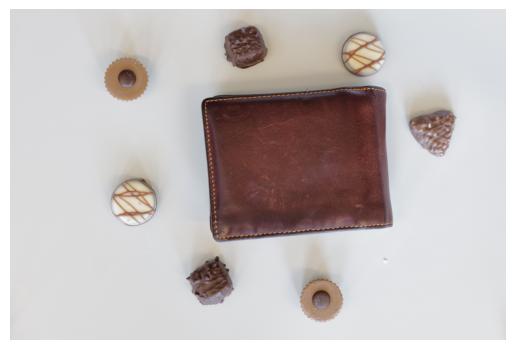

In [5]:
# path definitions
path_to_ref = "./dataset/references"
path_to_train = "./dataset/train"
path_to_test = "./dataset/test"

path_to_labels = "./dataset/train.csv"
path_to_submission = "./dataset/sample_submission.csv"

assert os.path.exists(path_to_ref), "ERROR: references folder not found"
assert os.path.exists(path_to_train), "ERROR: train folder not found"
assert os.path.exists(path_to_test), "ERROR: test folder not found"
assert os.path.exists(path_to_labels), "ERROR: labels for training not found"
assert os.path.exists(path_to_submission), "ERROR: submission file not found"

# CHOCO TYPES
amandina = "1. Amandina"
arabia = "2. Arabia"
comtesse = "3. Comtesse"
creme_brulee = "4. Crème brûlée"
jelly_black = "5. Jelly black"
jelly_milk = "6. Jelly milk"
jelly_white = "7. Jelly white"
noblesse = "8. Noblesse"
noir_authentique = "9. Noir authentique"
passion_lait = "10. Passion au lait"
stracciatella = "11. Stracciatella"
tentation_noir = "12. Tentation noir"
triangolo = "13. Triangolo"

# TEST IMAGE
amandina_path = os.path.join(path_to_ref, "Amandina.JPG")
arabia_path = os.path.join(path_to_ref, "Arabia.JPG")
comtesse_path = os.path.join(path_to_ref, "Comtesse.JPG")
train1_path = os.path.join(path_to_train, "L1000791.JPG")
test1_path = os.path.join(path_to_test, "L1000819.JPG")

amandina_img = load_and_show_image(amandina_path)
arabia_img = load_and_show_image(arabia_path)
comtesse_img = load_and_show_image(comtesse_path)
train1_img = load_and_show_image(train1_path)
test1_img = load_and_show_image(test1_path)

### Data investigation

In [6]:
print("amandina shape: ", amandina_img.shape)
print("arabia shape: ", arabia_img.shape)
print("comtesse shape: ", comtesse_img.shape)
print("training image shape: ", train1_img.shape)
print("testing image shape: ", test1_img.shape)

# ref images are all 4000x6000 pixels, 3 channels (RGB i guess)

amandina shape:  (4000, 6000, 3)
arabia shape:  (4000, 6000, 3)
comtesse shape:  (4000, 6000, 3)
training image shape:  (4000, 6000, 3)
testing image shape:  (4000, 6000, 3)


In [7]:
# load labels -> the csv file with labels for the training dataset is structured as a matrix
# with 14 columns (name of the training image + counts for each of the 13 chocolate categories)
# and 91 rows (header + 90 images)

train_filenames, train_labels = load_labels_csv(path_to_labels)
print(train_filenames.shape)     # -> (90,)
print(train_labels.shape)   # -> (90, 13)

print(train_filenames)

(90,)
(90, 13)
[1000756 1000763 1000765 1000768 1000772 1000779 1000780 1000785 1000788
 1000791 1000792 1000793 1000797 1000799 1000802 1000804 1000808 1000810
 1000812 1000815 1000817 1000826 1000827 1000828 1000831 1000843 1000844
 1000850 1000851 1000854 1000859 1000866 1000870 1000872 1000875 1000876
 1000880 1000882 1000885 1000888 1000890 1000894 1000896 1000899 1000900
 1000903 1000909 1000910 1000914 1000916 1000923 1000926 1000928 1000930
 1000932 1000939 1000941 1000946 1000951 1000952 1000957 1000963 1000964
 1000965 1000971 1000972 1000974 1000977 1000979 1000981 1000987 1000989
 1000992 1000993 1001000 1010004 1010008 1010009 1010012 1010014 1010015
 1010019 1010022 1010026 1010029 1010031 1010032 1010035 1010041 1010045]


In [8]:
from pathlib import Path

def load_jpg_folder(path_to_folder):
    """
    Load every *.jpg / *.jpeg image in a directory into one NumPy tensor.

    Parameters
    ----------
    path_to_folder : str
        Directory that contains the JPEG files.
    as_gray : bool, default True
        • True  → convert each image to 8‑bit grayscale and return
                  an array of shape (N, H, W).
        • False → keep the original RGB data and return an array
                  of shape (N, H, W, 3).

    Returns
    -------
    images : np.ndarray
        Image stack with dtype uint8.  H × W (and channels) are the
        same for **all** images.

    Raises
    ------
    ValueError
        If the folder contains no JPEG files or if the images do not
        all share identical dimensions.
    """
    folder = Path(path_to_folder).expanduser()
    files  = sorted(
        f for f in folder.iterdir()
        if f.suffix.lower() in {".jpg", ".jpeg"}
    )

    if not files:
        raise ValueError(f"No JPEG files found in {folder!s}")

    # Load the first image to establish reference size and mode
    ref_img = Image.open(files[0])
    ref_img = ref_img.convert("RGB")

    ref_arr = np.asarray(ref_img, dtype=np.uint8)
    H, W    = ref_arr.shape[:2]
    channels = 3
    stacks   = [ref_arr]

    # Load the remaining images, checking for size consistency
    for f in files[1:]:
        img = Image.open(f).convert("RGB")
        if img.size != (W, H):        # PIL size = (width, height)
            raise ValueError(
                f"Image {f.name} has size {img.size}, "
                f"expected {(W, H)}"
            )
        stacks.append(np.asarray(img, dtype=np.uint8))

    # Shape (N, H, W[, 3])
    images = np.stack(stacks, axis=0)
    return images

In [9]:
# LOAD REFERENCE IMAGES

ref_img = load_jpg_folder(path_to_ref)

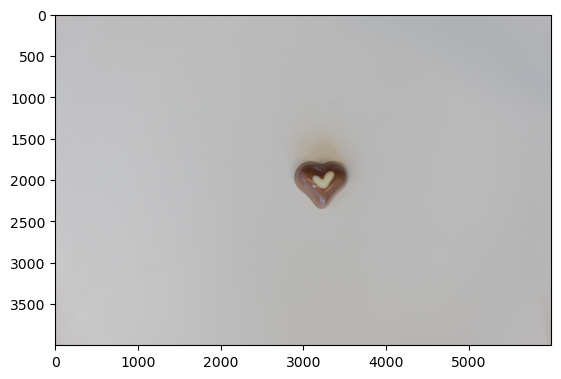

In [10]:
# test

plt.imshow(ref_img[9])

GENERAL PREPROCESS OR NO NEED???? --> i think the quality of all the images looks good + they said "All photos were taken under the same conditions — using the same camera, at the same distance, and with the same resolution"

# 1) SEGMENTATION

### --- Background separation ---

#### First, let's try thresholding

- Black chocolate's color:
R: 30-43
G: 15-28
B: 15-21

- Milk chocolate's color:
R: 70-135
G: 49-90
B: 25-53

- White chocolate's color:
R: 170-220
G: 160-211
B: 120-220

--> RGB variate too much

In [11]:
def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    # ------------------
    # Your code here ... 
    # ------------------
    img_hsv = rgb2hsv(img)
    
    data_h = img_hsv[:,:,0]
    data_s = img_hsv[:,:,1]
    data_v = img_hsv[:,:,2]
    
    return data_h, data_s, data_v

def plot_colors_histo(img: np.ndarray, data_h: np.ndarray, data_s: np.ndarray, data_v: np.ndarray, labels: list[str]):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(data_h[mask].flatten(), data_s[mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(data_h[mask].flatten(), data_v[mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(data_s[mask].flatten(), data_v[mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()

def apply_hsv_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    # Your code here ... 
    # ------------------
    img_th = (data_s > 0.05) & (data_v < 0.5) 

    return  img_th

def plot_thresholded_image(img: np.ndarray, thresholeded_img: np.ndarray, title: str):
    """
    Plot the original image and its thresholded version

    Args
    ----
    img: np.ndarray (M, N, 3)
        Input image of shape MxNx3.
    title: str
        Title of the plot
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img)
    axes[1].imshow(thresholeded_img, interpolation=None)
    [a.axis('off') for a in axes]
    plt.suptitle(title)
    plt.tight_layout()

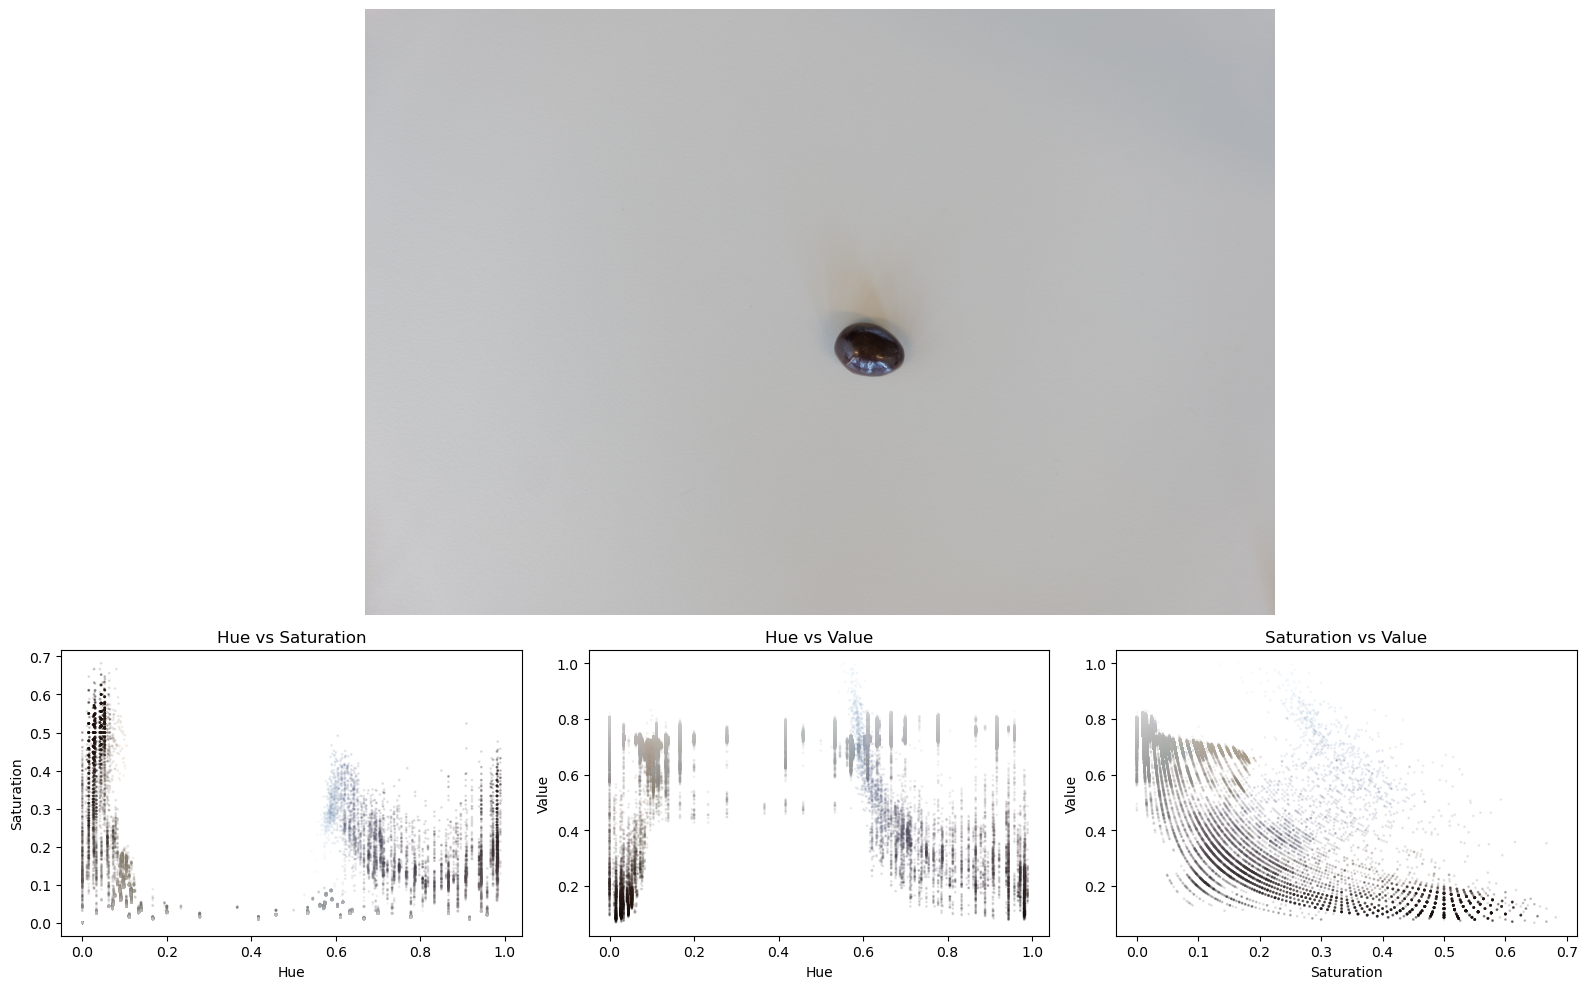

In [13]:
# test
img = ref_img[4]
labels = ["Hue", "Saturation", "Value"]
hue, sat, val = extract_hsv_channels(img)
plot_colors_histo(img, hue, sat, val, labels)

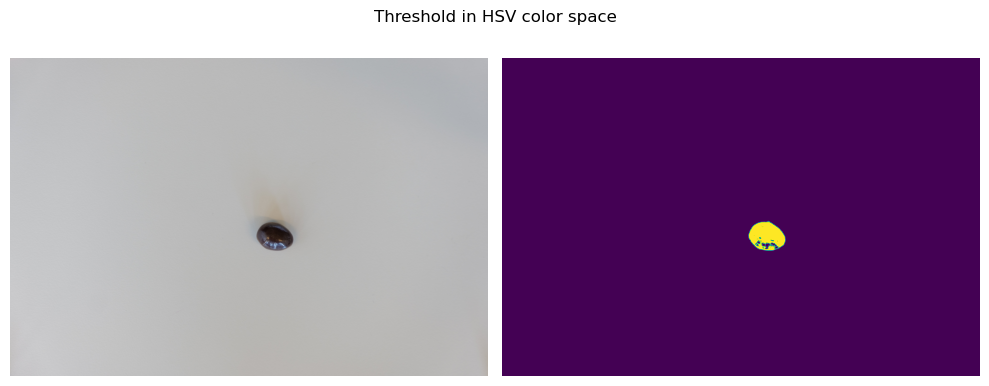

In [14]:
# test part 2
thresholded_img = apply_hsv_threshold(img)
plot_thresholded_image(img, thresholded_img, "Threshold in HSV color space")

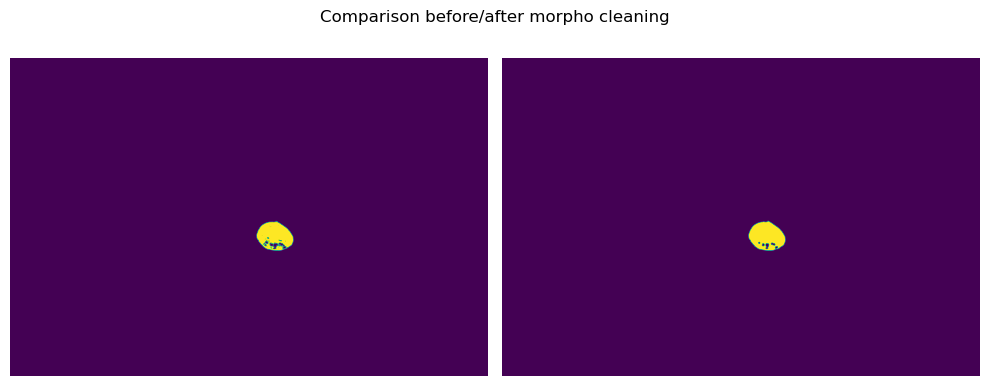

In [15]:
# morpho

img_morph = remove_small_holes(thresholded_img, 500)
img_morph = closing(img_morph, disk(10))
plot_thresholded_image(thresholded_img, img_morph, "Comparison before/after morpho cleaning")

#### Then, let's try region growing

In [152]:
from collections import deque
from scipy import ndimage as ndi
from skimage import color, filters, morphology, measure, exposure
from skimage.segmentation import watershed

def compute_seeds_ref_img(img, *, min_area=50):
    gray = color.rgb2gray(img) if img.ndim == 3 else img
    # Threshold: chocolates are darker than background
    t = filters.threshold_otsu(gray)
    mask = gray < t  # keep dark regions

    # Clean small blobs / noise
    mask = morphology.remove_small_objects(mask, min_size=min_area)
    mask = morphology.binary_opening(mask, morphology.disk(3))

    # Label and extract regions
    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)

    largest_region = max(regions, key=lambda r: r.area)
    centroid = tuple(map(int, largest_region.centroid))

    return [centroid]


def compute_seeds(
    img,
    *,
    min_area = 10000,          # discard blobs smaller than this (px)
    max_area: int = 500000,  # discard big objects
    gaussian_sigma = 1.0  # pre–blur for noise robustness
):
    """
    Detect candidate seed points for region growing.

    Parameters
    ----------
    img : (H, W, 3) or (H, W) ndarray
        Input image as uint8 / float in [0, 255] or [0, 1].
    min_area : int, optional
        Blobs with fewer pixels are ignored.
    gaussian_sigma : float, optional
        Std-dev used to blur before thresholding.

    Returns
    -------
    seeds : list[tuple[int, int]]
        List of (row, col) seed coordinates.
    """

    # Pre‑blur (suppresses fine texture / noise)
    img_blur = ndi.gaussian_filter(img, sigma=gaussian_sigma)

    # Thresholding
    gray = color.rgb2gray(img_blur) if img_blur.ndim == 3 else img_blur
    t = filters.threshold_otsu(gray)
    mask = gray < t


    #edges = filters.sobel(gray)
    #t_edge = filters.threshold_otsu(edges)
    #mask = edges > t_edge
    #mask = morphology.binary_dilation(mask, morphology.disk(2))
    #mask = ndi.binary_fill_holes(mask)

    # Morphological clean‑up
    mask = morphology.remove_small_objects(mask, min_size=min_area)
    mask = morphology.binary_opening(mask, morphology.disk(3))

    # Connected‑component labelling
    labeled, _ = ndi.label(mask)
    regions = measure.regionprops(labeled)
    print("Number of regions found:", len(regions))

    # Collect seed points (integer centroids)
    seeds = []
    for region in regions:
        print(f"area: {region.area}")
        if min_area <= region.area <= max_area:
            seeds.append(tuple(map(int, region.centroid)))

    return seeds, mask


def region_growing(
        img: np.ndarray,
        seeds,
        tol: float = 5.0,
        connectivity: int = 8
    ):
    """Region–growing segmentation.

    This version automatically converts an RGB image to grayscale using
    *skimage.color.rgb2gray*, so you can pass either a 2D grayscale array
    or a 3D (H,W,3) RGB array.

    Parameters
    ----------
    img : ndarray
        2D grayscale or 3D RGB image.  Accepts uint8/16 or float.
    seeds : iterable of (row, col)
        Starting pixels known to belong to the desired region.
    tol : float, default 5.0
        Maximum |I(p) – I(region_mean)| allowed for a pixel to join the
        region.  Adapt *tol* to your image dynamic range.
    connectivity : {4,8}, default 8
        Pixel neighbourhood definition.

    Returns
    -------
    mask : 2D boolean ndarray
        Pixels labelled **True** belong to the grown region.
    """

    # ---- 1.  Ensure grayscale ------------------------------------------------
    if img.ndim == 3 and img.shape[-1] == 3:
        # skimage.rgb2gray returns float32/64 in [0, 1].  Bring back to the
        # original scale if the input was uint‑type for tol consistency.
        gray = rgb2gray(img)
        if img.dtype == np.uint8:
            img = (gray * 255).astype(np.float32)
        elif img.dtype == np.uint16:
            img = (gray * 65535).astype(np.float32)
        else:
            img = gray.astype(np.float32)
    elif img.ndim == 2:
        img = img.astype(np.float32)
    else:
        raise ValueError("img must be 2‑D grayscale or 3‑D RGB image")

    h, w = img.shape

    # ---- 2.  Init ------------------------------------------------------------
    seeds = [(int(r), int(c)) for r, c in seeds]
    mask     = np.zeros((h, w), dtype=bool)
    visited  = np.zeros_like(mask)
    q        = deque()

    seed_vals = [img[r, c] for r, c in seeds]
    region_mean = float(np.mean(seed_vals))

    for r, c in seeds:
        q.append((r, c))
        visited[r, c] = True
        mask[r, c]    = True

    # ---- 3.  Choose neighbourhood offsets -----------------------------------
    if connectivity == 4:
        nbrs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectivity == 8:
        nbrs = [(-1, 0), (1, 0), (0, -1), (0, 1),
                (-1, -1), (-1, 1), (1, -1), (1, 1)]
    else:
        raise ValueError("connectivity must be 4 or 8")

    # ---- 4.  Grow ------------------------------------------------------------
    region_size = len(seeds)
    while q:
        r, c = q.popleft()
        for dr, dc in nbrs:
            nr, nc = r + dr, c + dc
            if 0 <= nr < h and 0 <= nc < w and not visited[nr, nc]:
                visited[nr, nc] = True
                if abs(float(img[nr, nc]) - region_mean) <= tol:
                    mask[nr, nc] = True
                    q.append((nr, nc))

                    # online update of the mean intensity
                    region_size += 1
                    region_mean += (float(img[nr, nc]) - region_mean) / region_size

    return mask

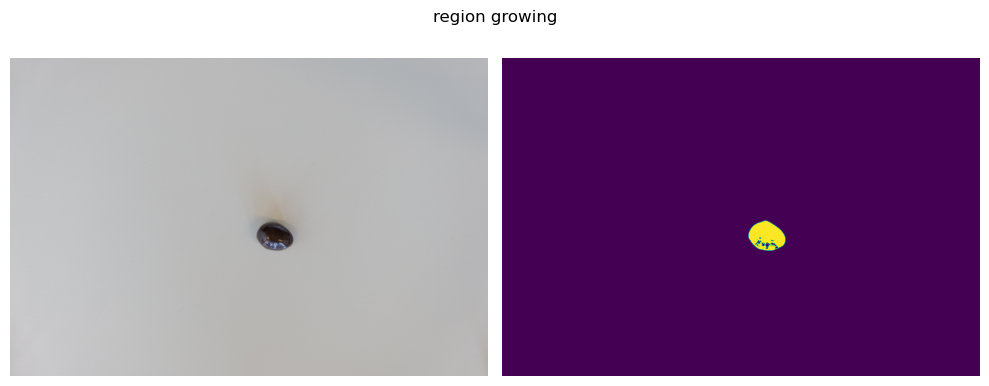

In [123]:
# test region growing

# test manual seeds
#seeds = [
#        (2220,3328), (2200,3340), (2225,3320)
#    ]

seeds = compute_seeds_ref_img(img)

img_grow = region_growing(img, seeds, tol=70) # = mask of where the chocolate is (true/false)
plot_thresholded_image(img, img_grow, "region growing")

Number of regions found: 4
area: 200366.0
area: 187956.0
area: 181602.0
area: 455806.0


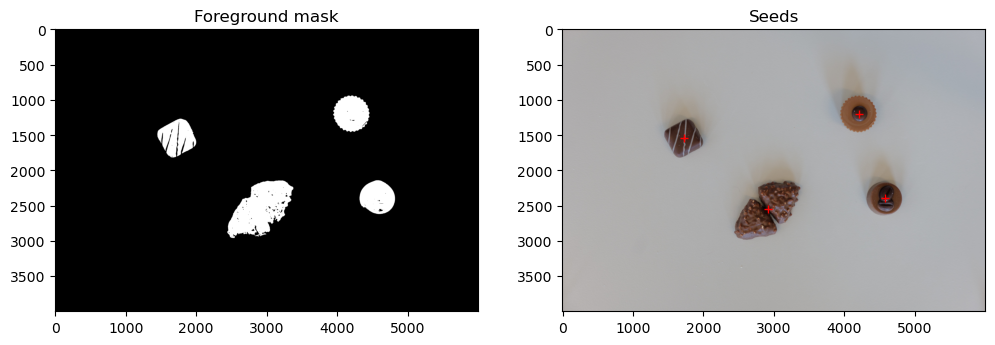

In [153]:
# test seed for training image

seeds_training, mask = compute_seeds(train1_img)

plt.figure(figsize=(12, 5))
plt.subplot(121); plt.imshow(mask, cmap='gray'); plt.title("Foreground mask")
plt.subplot(122); plt.imshow(train1_img); plt.title("Seeds")
for y, x in seeds_training:
    plt.plot(x, y, 'r+')
plt.show()

Number of regions found: 536
area: 6601648.0
area: 58.0
area: 248849.0
area: 17788.0
area: 18783.0
area: 29.0
area: 360.0
area: 84.0
area: 29.0
area: 57.0
area: 13834.0
area: 10086.0
area: 21488.0
area: 20499.0
area: 56277.0
area: 135.0
area: 10799.0
area: 42.0
area: 2050.0
area: 12351.0
area: 197.0
area: 117.0
area: 235.0
area: 198.0
area: 437.0
area: 29.0
area: 81.0
area: 29.0
area: 155.0
area: 82.0
area: 150.0
area: 44.0
area: 41.0
area: 12909.0
area: 49.0
area: 56414.0
area: 51.0
area: 64.0
area: 55.0
area: 36.0
area: 29.0
area: 113.0
area: 36.0
area: 115.0
area: 161.0
area: 29.0
area: 221.0
area: 36.0
area: 29.0
area: 29.0
area: 187.0
area: 1533.0
area: 29.0
area: 29.0
area: 167.0
area: 38.0
area: 29.0
area: 57.0
area: 43.0
area: 43.0
area: 62.0
area: 44.0
area: 273.0
area: 63.0
area: 264.0
area: 112.0
area: 38.0
area: 128.0
area: 332.0
area: 2096.0
area: 58350.0
area: 41.0
area: 378.0
area: 2069.0
area: 2351.0
area: 53.0
area: 164.0
area: 36.0
area: 122.0
area: 2864.0
area: 29.0


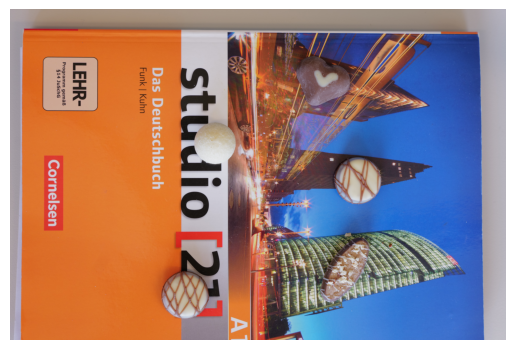

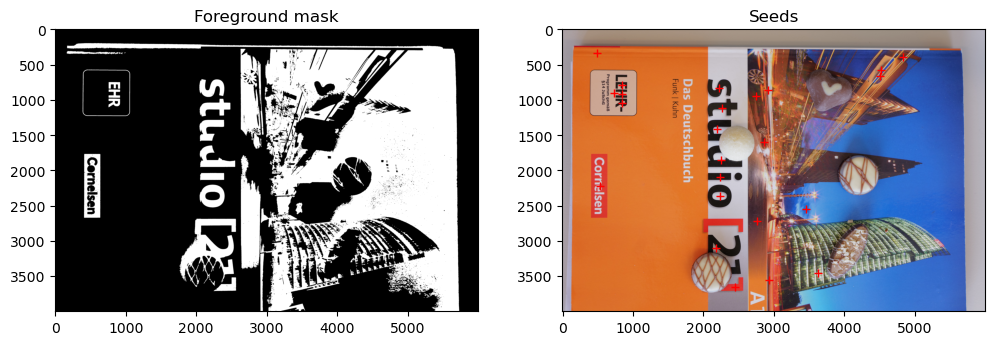

In [156]:
train2_path = os.path.join(path_to_train, "L1000859.JPG")
train2_img = load_and_show_image(train2_path)

seeds_training2, mask2 = compute_seeds(train2_img)

plt.figure(figsize=(12, 5))
plt.subplot(121); plt.imshow(mask2, cmap='gray'); plt.title("Foreground mask")
plt.subplot(122); plt.imshow(train2_img); plt.title("Seeds")
for y, x in seeds_training2:
    plt.plot(x, y, 'r+')
plt.show()

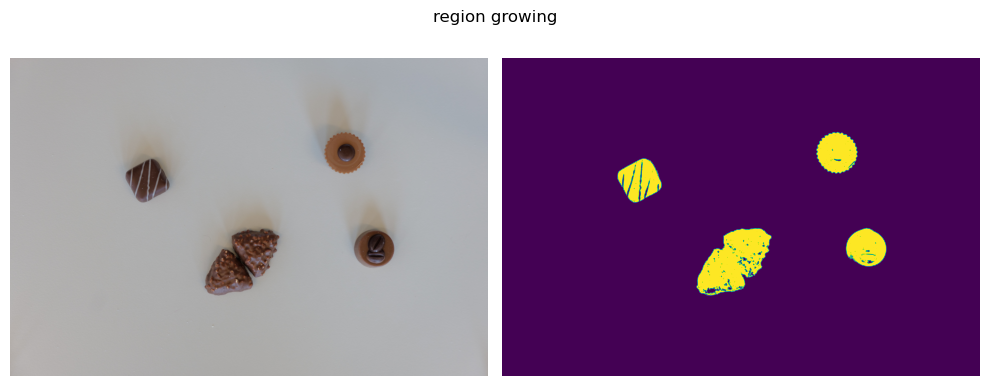

In [145]:
train_reg_grow = region_growing(train1_img, seeds_training, tol=55) # = mask of where the chocolate is (true/false)
plot_thresholded_image(train1_img, train_reg_grow, "region growing")

Number of seeds: 1


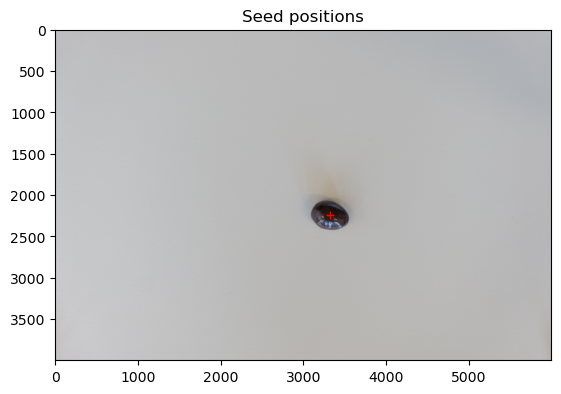

In [122]:
# test seed for reference image

print("Number of seeds:", len(seeds))
plt.imshow(img)
for y, x in seeds:
    plt.plot(x, y, 'r+')
plt.title("Seed positions")
plt.show()

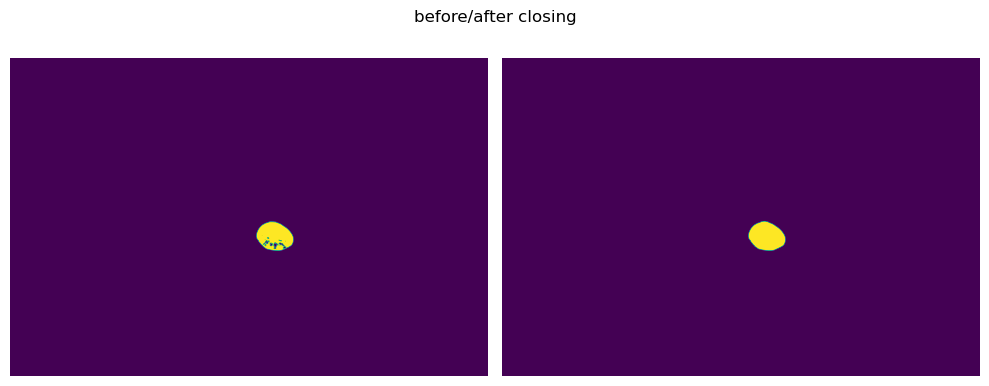

In [44]:
# trying to fill holes in chocolate due to light
img_grow_final = closing(img_grow, footprint=disk(20))
plot_thresholded_image(img_grow, img_grow_final, "before/after closing")


# else: i heard about the function binary_fill_holes from scipy but im not sure we're allowed to use it... but it's more efficient and gives same result

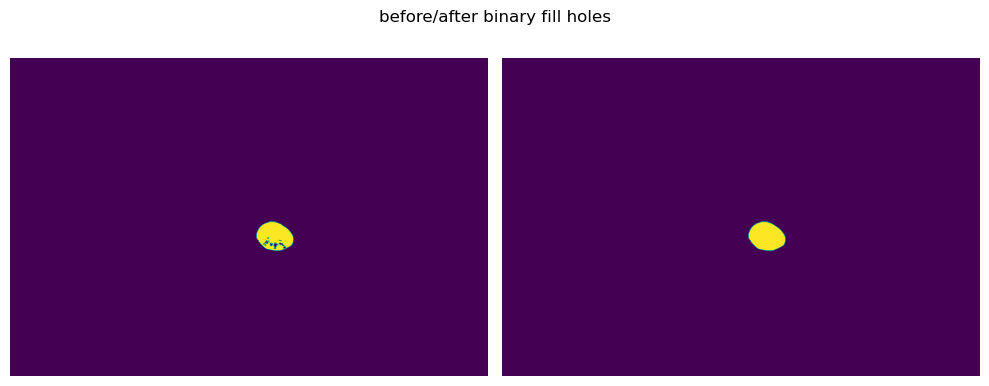

In [46]:
from scipy.ndimage import binary_fill_holes

test = binary_fill_holes(img_grow)
plot_thresholded_image(img_grow, test, "before/after binary fill holes")

# 2) OBJECT DESCRIPTION

Generate descriptors for each reference image!! (= clean isolated prototypes --> = class centers for classifier) --> to do so:
1. segment them using step 1
2. extract & store descriptor vectors from each of 13 ref img

Later: training images --> apply same descriptor extraction to enrich training set

In [58]:
def find_contour(images: np.ndarray):
    """
    Find the contours for the set of images
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images to process

    Return
    ------
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    """

    # Get number of images to process
    N, _, _ = np.shape(images)
    # Fill in dummy values (fake points)
    contours = [np.array([[0, 0], [1, 1]]) for i in range(N)]

    for i in range(N):
        image = images[i]

        # openCV version -> PB = OPENCV FINDCONTOUR RETURNS TUPLES, NOT LISTS!!!!
        #contours[i], hierarchy = cv2.findContours(image, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_NONE)
        #contours[i] = contours[i].squeeze(axis=1)
        
        # or use skimage -> returns list:
        # /!\ returns [row=y, column=x] coordinates /!\
        contours[i] = find_contours(image, level=0.5) # play with level parameter --> HOW????
        largest_contour = max(contours[i], key=lambda c: len(c))
        largest_contour = largest_contour[:, ::-1]  # swap coordinate system
        contours[i] = largest_contour

    return contours

def find_contour_single(image: np.ndarray):
    """
    Find the contours for the image
    
    Args
    ----
    image: np.ndarray (N, 28, 28)
        Source images to process

    Return
    ------
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    """

    # Fill in dummy values (fake points)
    contours = np.array([[0, 0], [1, 1]])

    image_corrected = (image > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(image_corrected, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    largest_contour = largest_contour.squeeze()

    return largest_contour

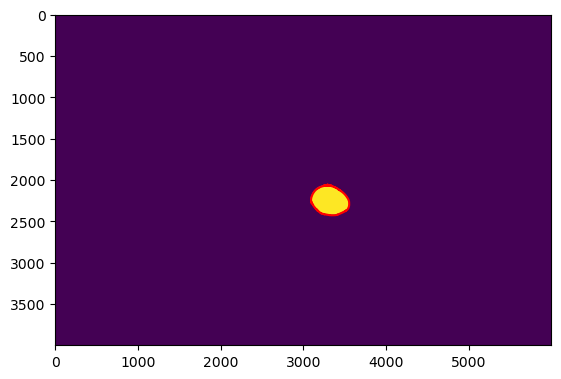

In [59]:
contours = find_contour_single(test)

plt.imshow(test)
plt.plot(contours[:, 0], contours[:, 1], 'r-')

## a) Region-based descriptors

i think the revelant ones can be:

1) For shape & contour

- elongation (long vs round chocolates)
- rectangularity (square vs circular or irregular shapes)
- compacity (compact round vs irregular shapes like heart or triangle)

2) Size -> area

3) Orientation / symmetry & internal structure: moments

In [77]:
def compute_region_descriptors(binary_mask):
    """
    Compute region-based descriptors from a binary mask of a segmented chocolate.

    Parameters:
        binary_mask (np.ndarray): Binary image (uint8) where the object has value 1 (or 255), and background is 0.

    Returns:
        dict: Dictionary of descriptors: area, elongation, rectangularity, compacity, and Hu moments.
    """
    # Mask should be uint8
    mask_u8 = (binary_mask>0).astype(np.uint8) * 255

    # Find contours for rectangularity calculation
    contour = find_contour_single(binary_mask)

    # Area
    area = cv2.contourArea(contour)

    # Rectangularity
    x, y, w, h = cv2.boundingRect(contour)
    rectangularity = area / (w*h)

    # Compacity (C = 4πA / P²)
    perimeter = cv2.arcLength(contour, True)
    compacity = (4 * np.pi * area) / (perimeter ** 2)

    # Moments and Elongation
    M = cv2.moments(mask_u8, binaryImage=True)
    cov = np.array([[M['mu20'], M['mu11']],
                [M['mu11'], M['mu02']]])
    eig = np.sort(np.linalg.eigvals(cov))[::-1]
    elongation = np.sqrt(eig[0] / eig[1]) if eig[1] else 0 

    hu = cv2.HuMoments(M).flatten().tolist()

    return {
        'area': area,
        'rectangularity': rectangularity,
        'compacity': compacity,
        'elongation': elongation,
        'hu_moments': hu
    }

In [78]:
# test

descriptors = compute_region_descriptors(test)

for k, v in descriptors.items():
    print(f"{k:15s} : {v}")


area            : 125792.0
rectangularity  : 0.7311362975879105
compacity       : 0.5037777169244994
elongation      : 1.332311224372674
hu_moments      : [0.16620164762588158, 0.0021547210244123854, 2.959935451072076e-05, 8.579839400555722e-07, 4.3232117561025414e-12, 3.973942103308781e-08, 6.776768861009789e-14]


In [83]:
# sanity check

h, w = test.shape
non_zero = np.count_nonzero(test)
print("mask size :", w, "×", h)
print("foreground:", non_zero, "px")
print("bounding box (w, h):", cv2.boundingRect(find_contour_single(test))[-2:])

mask size : 6000 × 4000
foreground: 126542 px
bounding box (w, h): (465, 370)


## b) Fourier descriptors (contour-based)

fair comparison between the Fourier descriptors => we need to ensure that all descriptors have the same length (padding)

BUT /!\ 0 padding = cheap and inefficient way to ensure homogeneity in length /!\ -> tested here and output = shit. --> use interpolation instead (ensure that we have the same number of points along the contour for each digit)

--> + MAKE THE DESCRIPTOR INVARIANT TO TRANSLATION, ROTATION & SCALING!!!!

In [85]:
def linear_interpolation(contours: np.ndarray, n_samples: int = 11):
    """
    Perform interpolation/resampling of the contour across n_samples.
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider along the contour.

    Return
    ------
    contours_inter: np.ndarray (N, n_samples, 2)
        Interpolated contour with n_samples
    """

    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))

    for i, c in enumerate(contours):
        x = c[:,0]
        y = c[:,1]
        K = len(c)
        t = np.zeros(K)

        # compute time steps array t (cumulative distance along contour) --> on peut aussi utiliser euclidean_distances importé mais rien capté
        for j in range(1, K):
            dist = np.sqrt((x[j] - x[j-1])**2 + (y[j] - y[j-1])**2)
            t[j] = t[j-1] + dist
        
        # new time steps from 0 to t[-1] with n_samples nb of pts
        t_new = np.linspace(0, t[-1], n_samples)

        x_new = np.interp(t_new, t, x)
        y_new = np.interp(t_new, t, y)
        contours_inter[i,:,0] = x_new
        contours_inter[i,:,1] = y_new

    return contours_inter

def linear_interpolation_single(contour: np.ndarray, n_samples: int = 11):
    """
    Perform interpolation/resampling of a single contour across n_samples.

    Args
    ----
    contour: np.ndarray
        Array of 2D coordinates (K, 2) representing the contour, 
        where K is the number of contour points.
    n_samples: int
        Number of samples to consider along the contour.

    Return
    ------
    contour_inter: np.ndarray (n_samples, 2)
        Interpolated contour with n_samples points.
    """

    x = contour[:, 0]
    y = contour[:, 1]
    K = len(contour)
    t = np.zeros(K)

    # Compute cumulative distances (used as "time")
    for j in range(1, K):
        dist = np.sqrt((x[j] - x[j-1])**2 + (y[j] - y[j-1])**2)
        t[j] = t[j-1] + dist

    # Create uniform sampling points along the cumulative length
    t_new = np.linspace(0, t[-1], n_samples)

    # Interpolate x and y coordinates separately
    x_new = np.interp(t_new, t, x)
    y_new = np.interp(t_new, t, y)

    contour_inter = np.stack((x_new, y_new), axis=1)

    return contour_inter


def compute_single_descriptor_interpolated(contour: np.ndarray, n_samples: int = 11):
    """
    Compute Fourier descriptor of a single contour with interpolation 
    when the number of points is less than n_samples.

    Args
    ----
    contour: np.ndarray
        Array of 2D coordinates (K, 2) representing the contour, 
        where K is the number of contour points.
    n_samples: int
        Number of samples to consider. The contour is resampled to exactly n_samples 
        using linear interpolation before computing the FFT.

    Return
    ------
    descriptor: np.ndarray complex (n_samples,)
        Computed complex Fourier descriptor for the given input contour.
    """

    resampled_contour = linear_interpolation_single(contour, n_samples)
    complex_contour = resampled_contour[:, 0] + 1j * resampled_contour[:, 1]

    descriptor = np.fft.fft(complex_contour)

    return descriptor


def compute_reverse_descriptor(descriptor: np.ndarray, n_samples: int = 11):
    """
    Reverse a Fourier descriptor to xy coordinates given a number of samples.
    
    Args
    ----
    descriptor: np.ndarray (D,)
        Complex descriptor of length D.
    n_samples: int
        Number of samples to consider to reverse transformation.

    Return
    ------
    x: np.ndarray complex (n_samples,)
        x coordinates of the contour
    y: np.ndarray complex (n_samples,)
        y coordinates of the contour
    """

    x = np.zeros(n_samples)
    y = np.zeros(n_samples)

    reverse_fourier = np.fft.ifft(descriptor)

    if np.shape(reverse_fourier)[0] > n_samples:
        reverse_fourier = reverse_fourier[:n_samples]

    for i in range(n_samples):
        x[i] = reverse_fourier[i].real
        y[i] = reverse_fourier[i].imag

    return x, y

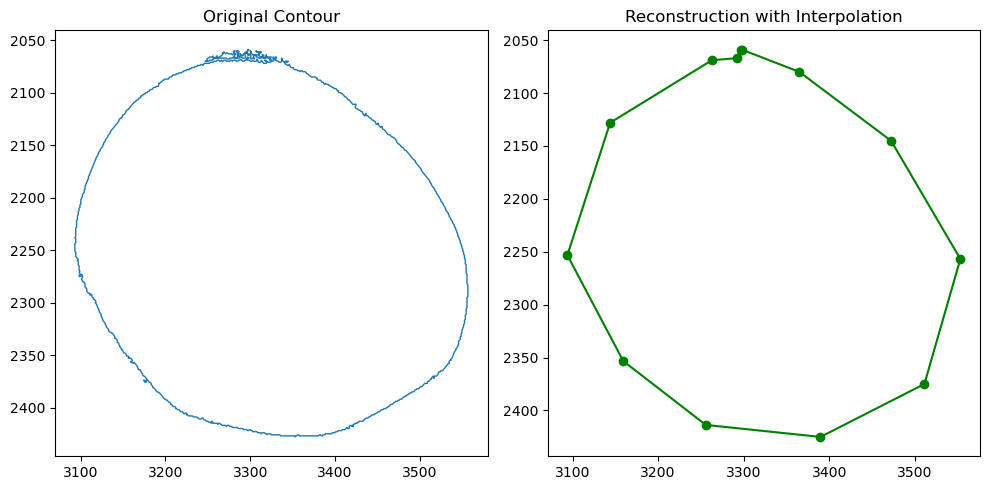

In [92]:
n_samples = 13

fourier_descriptor = compute_single_descriptor_interpolated(contours, n_samples=n_samples)
x_rev, y_rev = compute_reverse_descriptor(fourier_descriptor, n_samples)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(contours[:, 0], contours[:, 1], label="Original", lw=1)
plt.title("Original Contour")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.plot(x_rev, y_rev, 'g-o', label="Interpolation")
plt.title("Reconstruction with Interpolation")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## c) Texture / color descriptors --> à voir si mauvais résultats

features that can be added:
- mean/std of color channels (cheap & good when lighting = constant)
- normalised colour histogram (rotation/scale invariant)
- local binary pattern histogram (captures micro-texture like ridges, toppings)
- Gabor filter energies (good for ridged / striped pieces)

--> "If you fuse them with your existing shape/Fourier features, normalise each block (z‑score) before feeding the classifier."

In [93]:
from skimage.feature import local_binary_pattern
from skimage.filters import gabor

def color_mean_std(rgb: np.ndarray, mask: np.ndarray):
    """Mean and standard deviation of each RGB channel inside mask.

    Parameters
    ----------
    rgb : ndarray, shape (H, W, 3), uint8 or float
    mask : bool ndarray, shape (H, W)
        True for pixels that belong to the object.

    Returns
    -------
    feat : 1‑D float array, length 6  = [R̄, Ḡ, B̄, σR, σG, σB]
    """
    assert rgb.ndim == 3 and rgb.shape[-1] == 3, "rgb must be H×W×3"
    pix = rgb[mask]                     # (N, 3)
    mean = pix.mean(axis=0)
    std = pix.std(axis=0)
    return np.concatenate([mean, std])


def color_hist(rgb: np.ndarray, mask: np.ndarray, bins: int = 8):
    """Concatenated, L1‑normalised histograms of each colour channel.

    By default returns 24 numbers (8 bins × 3 channels).
    """
    pix = rgb[mask]
    if pix.dtype != np.float32 and pix.dtype != np.float64:
        # scale 0‑255 → 0‑1 for consistent binning
        pix = pix.astype(float) / 255.0
    hists = []
    for ch in range(3):
        hist, _ = np.histogram(pix[:, ch], bins=bins, range=(0.0, 1.0), density=False)
        hist = hist.astype(float)
        hist /= hist.sum() + 1e-12         # L1 normalise
        hists.append(hist)
    return np.concatenate(hists)


def lbp_hist(rgb: np.ndarray, mask: np.ndarray, P: int = 8, R: float = 1.0,
             method: str = "uniform"):
    """Rotation‑invariant LBP histogram inside the mask.

    Parameters
    ----------
    P, R : classical LBP neighbourhood parameters.
    method : 'uniform' gives (P+2) unique codes.

    Returns
    -------
    hist : 1‑D float array, length depends on method (for 'uniform', P+2).
    """
    gray = rgb2gray(rgb)
    lbp = local_binary_pattern(gray, P=P, R=R, method=method)
    lbp = lbp[mask]
    n_bins = int(lbp.max()) + 1
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=False)
    hist = hist.astype(float)
    hist /= hist.sum() + 1e-12
    return hist


def gabor_energy(rgb: np.ndarray, mask: np.ndarray,
                 frequencies: tuple[float, ...] = (0.1, 0.2, 0.3),
                 thetas: tuple[float, ...] = (0, np.pi / 4, np.pi / 2, 3 * np.pi / 4)) -> np.ndarray:
    """Sum of absolute Gabor responses at multiple (frequency, θ) pairs.

    The default bank yields 3 frequencies × 4 orientations = 12 features.
    """
    gray = rgb2gray(rgb)
    feats = []
    for f in frequencies:
        for theta in thetas:
            real, imag = gabor(gray, frequency=f, theta=theta)
            energy = np.abs(real + 1j * imag)[mask].mean()
            feats.append(energy)
    return np.array(feats, dtype=float)

In [94]:
print("mean/std:", color_mean_std(img, test).shape)
print("colour hist:", color_hist(img, test).shape)
print("LBP hist:", lbp_hist(img, test).shape)
# print("Gabor energy:", gabor_energy(img, test).shape) # ---> A MIS 9 MIN A RUN !!!!!!


mean/std: (6,)
colour hist: (24,)


/Users/romy/opt/anaconda3/envs/iapr/lib/python3.9/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP hist: (10,)
Gabor energy: (12,)


## ALSO USE DISTANCE MAP (cf LAB 2) OR NOT???? OVERFITTING????

## d) Feature fusion for classification

In [103]:
features = np.concatenate([
    np.atleast_1d(descriptors),
    fourier_descriptor,
    color_mean_std(img, test),
    color_hist(img, test, bins=8),
    lbp_hist(img, test, R=1)
])

/Users/romy/opt/anaconda3/envs/iapr/lib/python3.9/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [104]:
# LATER TO TEST EACH BLOCK

def full_descriptor(img, mask, contour, use_color=True, use_texture=True):
    desc = [
        np.atleast_1d(descriptors),
        fourier_descriptor,
    ]
    if use_color:
        desc.extend([
            color_mean_std(img, mask),
            color_hist(img, mask)
        ])
    if use_texture:
        desc.append(lbp_hist(img, mask))
    return np.concatenate(desc)



features = full_descriptor(img, test, contours, False, False)

In [102]:
print(features)

[{'area': 125792.0, 'rectangularity': 0.7311362975879105, 'compacity': 0.5037777169244994, 'elongation': 1.332311224372674, 'hu_moments': [0.16620164762588158, 0.0021547210244123854, 2.959935451072076e-05, 8.579839400555722e-07, 4.3232117561025414e-12, 3.973942103308781e-08, 6.776768861009789e-14]}
 (43093.00914498161+28684.250000000004j)
 (-150.59182462664296-144.77228792090978j)
 (0.3856997634314965-275.14617865799005j)
 (8.513953393397887-40.7785557040811j)
 (-9.06563630506038+22.297158917923696j)
 (20.370109777589313+14.86147332522475j)
 (16.473130169994263-13.62595471167782j)
 (37.087921906323274+6.990779453467837j)
 (15.419162844617825-34.66335522854885j)
 (-76.37379481511003-71.45611111415423j)
 (13.236395569001697+181.322058710874j)
 (-42.2293018684535+797.3351572399995j)
 (-65.23496079069615-2359.614184310126j)]


# 3) CLASSIFICATION

## a) Feature normalisation

## b) Classifier & training

don't forget:
- OoD score & detection (Mahalanobis distance?)
- pooling?
- cross-validation?

## c) Testing

# --- SUBMISSION FILE CREATION ---